In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import networkx as nx
from pylab import rcParams
from math import *
import time
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from math import log, exp, ceil, sqrt
from sklearn.model_selection import train_test_split
import warnings
import json
warnings.filterwarnings('ignore', category=UserWarning)

from DiTree import *

REVISED VERSION:

DIRECTED CASE (alg 1):
- 3 different settings for (a,b)
- 2 different settings for graph: star (10 nodes, agents 0-4 nonzero), random graph (100 nodes, agents 0-94 nonzero)
- plots: current plots + additional upper level objective values


for star graph: R matrix == every node point toward center, C matrix == center to every node

UNDIRECTED STOCHASTIC CASE (alg 2):
- to generate data, treat b_i as a random variable (see paper), sample from dataset U(1,10) (uniform 1-10)
- also change plots: need expectation
- expectation of b_i = 5.5, for plots can use a deterministic function with 5.5 replaced everywhere

- run each for 5 samplepaths (tweak as needed for good plots) --- plot with confidence intervals
p 2 different settings for graph: petersen (10 nodes) and random (100 nodes)


- Total: 9 plots for each graph, 4 figures, save as 36 PDFs

CHANGELOG:
1. moreau smoothing parameter changed from 0.1 to 0.01 to guarantee convergence of lower level

In [2]:
# DIRECTED DETERMINISTIC ALGORITHM
# --------------------------------

In [3]:
# Setting up data
# ---------------

np.random.seed(1)
reg_weight = 0.1
moreau = 0.01
N = 10

"""
returns:
a_values (vector size N)
b_values (vector size N)
C matrix (matrix size NxN)
upper box constraints (vector size N)
lower box constraints (vector size N)
"""
# a_i ~U[1,10] for i = 0..14, and a_i = 0 for i = 15..19
# more generally, a_i = 0 for i = (n-5)..(n-1)
a_values = np.random.uniform(low=1, high=10, size=N)
a_values[-5:] = 0

# b_i ~U[1,10] for all i = 0..(n-1)
b_values = np.random.uniform(low=1, high=10, size=N)

# C is a positive definite matrix
A = np.random.randn(N,N)
B = A.dot(A.T)                                           # B is positive semidefinite
eigvals = LA.eigvals(B)
C = B + np.diagflat([min(eigvals)+1 for _ in range(N)]) # C is positive definite

# lower box constraint cannot exceed the upper box constraint
upper_box_constraints = np.random.uniform(low=50, high=100, size=N)
lower_box_constraints = np.random.uniform(low=0, high=upper_box_constraints, size=N)

In [4]:
# Graph generation
# ----------------

"""
Generates two directed star graph with N nodes, including central node.
The first star graph has only directed edges from the central node to all edge nodes.
The second star graph has only directed edges from the edge nodes to the central node.
"""
def star_graph(N):
    G_R, G_C = nx.DiGraph(), nx.DiGraph()
    G_R.add_nodes_from(range(N))
    G_C.add_nodes_from(range(N))
    for i in range(1,N):
        G_R.add_edge(0,i)
        G_C.add_edge(i,0)
    W_R = nx.to_numpy_array(G_R) + np.diag(np.ones(N))
    W_C = nx.to_numpy_array(G_C) + np.diag(np.ones(N))
    for i in range(N):
        W_R[0,i] = 1/N
        W_C[i,0] = 1/N
    return G_R, W_R, G_C, W_C

In [5]:
G_R, W_R, G_C, W_C = star_graph(10)

print(np.sum(W_R, axis=1))
print(np.sum(W_C, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
# Mappings and Gradient definitions
# ---------------------------------

"""
input: x is a vector size N
output: a scalar
"""
def f_fun(x):
    out = 0
    for i in range(len(x)):
        out += f_i(x,i)
    return out

"""
input: x is a vector size N
output: a scalar
"""
def f_i(x, i):
    x_i = x[i]
    return 0.5*a_values[i]*x_i**2 + b_values[i]*x_i \
               + (np.dot(C[i], x) - C[i,i]*x_i)*x_i \
               + LA.norm(x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))**2 / (2*moreau) \
               + 0.5*reg_weight*LA.norm(x)**2

"""
input: x is a vector size N
output: returns vector size N
"""
def grad_f_i(x, i):
    x_i = x[i]
    grad_f_i = C[i]*x_i
    grad_f_i[i] = a_values[i]*x_i + b_values[i] \
                    + (np.dot(C[i], x) - C[i,i]*x_i) \
                    + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return grad_f_i + reg_weight*x

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix A size N.N, where A[i] = ∇f_i(x_i) (bolded gradient f)
"""
def grad_f(X_mat):
    grad_f = np.zeros((N,N))
    for i in range(N):
        grad_f[i] = grad_f_i(X_mat[i], i)
    return grad_f

"""
input: x is a vector size N
output: returns sparse vector size N, where only the ith element is nonzero
"""
def F_i(x, i):
    F_i = np.zeros(N)
    x_i = x[i]
    F_i[i] = a_values[i]*x_i + b_values[i] \
               + (np.dot(C[i], x) - C[i,i]*x_i) \
               + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return F_i

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix size NxN: this is the bold F in the algorithm, not the unbolded F in the problem formulation
"""
def F_fun(X_mat):
    F = np.zeros((N,N))
    for i in range(N):
        F[i] = F_i(X_mat[i], i)
    return F

"""
input: x_avg_vec is a vector size N
output: returns vector size N: this is the unbolded F in the problem formulation
"""
def F_sum(x_avg_vec):
    F_vec = np.zeros(N)
    for i in range(N):
        F_vec += F_i(x_avg_vec, i)
    return F_vec

In [7]:
def DIR_DSGT(
    max_iter: int,
    epoch_size: int,
    X_0: np.ndarray,
    R_matrix: np.ndarray,
    C_matrix: np.ndarray,
    a_update_param,
    b_update_param,
    Gamma):

    m,_ = X_0.shape
    lower_vals = np.zeros(epoch_size + 1)
    delta_x_vals = np.zeros(epoch_size + 1)
    upper_vals = np.zeros(epoch_size + 1)
    consensus_vals = np.zeros(epoch_size + 1)
    X_next = X_0

    u = LA.eig(R_matrix.T)[1][0]
    u = u / np.mean(u) # try wrapping in np.real() if doesn't work right

    # update rules for stepsize (gamma_k) and regularization parameter (lambda_k)
    stepsize_rule = lambda x : 1e-10 / ((x+Gamma)**a_update_param)      # gamma_k
    regularizer_rule = lambda x : 1e-3 / ((x+Gamma)**b_update_param)    # lambda_k
    
    F_mat_next = F_fun(X_next)
    grad_f_mat_next = grad_f(X_next)
    
    # Y_0 is initialized to the gradient of the base function
    Y_next = F_mat_next + regularizer_rule(0) * grad_f(X_0)
    epoch_idx = 0
    
    for k in range(1, max_iter + 2):
        # updates:
        stepsize = stepsize_rule(k) * np.eye(m)
        lambda_k_now, lambda_k_next = regularizer_rule(k), regularizer_rule(k+1)
        X_now, Y_now = X_next, Y_next
        F_mat_now, grad_f_mat_now = F_mat_next, grad_f_mat_next

        # update X:    
        X_next = R_matrix.dot(X_now - np.dot(stepsize, Y_now))
        
        # update gradients:
        F_mat_next = F_fun(X_next)
        grad_f_mat_next = grad_f(X_next)
        
        # update Y tracker:
        Y_next = C_matrix.dot(Y_now) + (F_mat_next - F_mat_now) + (lambda_k_next * grad_f_mat_next - lambda_k_now * grad_f_mat_now)
        
        if max_iter == 0 or ((k-1) % ceil(max_iter/epoch_size)) == 0:
            x_ave_now = np.dot(u, X_now) / m
            x_ave_next = np.dot(u, X_next) / m

            lower_vals[epoch_idx] = LA.norm(F_sum(x_ave_now))
            delta_x_vals[epoch_idx] = LA.norm(x_ave_next-x_ave_now)
            upper_vals[epoch_idx] = f_fun(x_ave_now)
            consensus_vals[epoch_idx] = LA.norm(X_now - np.dot(np.ones((m,1)), x_ave_now.reshape(1,m)))
            epoch_idx += 1

    return lower_vals, delta_x_vals, upper_vals, consensus_vals

In [8]:
a_b_params = [(0.5, 0.3), (0.6, 0.25), (0.675, 0.2)]
runcolor  = { (0.5, 0.3): 'r', (0.6, 0.25): 'g', (0.675, 0.2): 'b' }
runmarker = { (0.5, 0.3): 'o', (0.6, 0.25): 'v', (0.675, 0.2): 's' }

Gamma = 10

max_iter = 10_000
epoch_size = 10
#if N == 10:
#    X_0 = np.random.normal(2, 0.2, size=(N,N))
#else:
X_0 = np.random.normal(1, 0.001, size=(N,N))
    
if N == 10:
    G_R, R_matrix, G_C, C_matrix = star_graph(N)
elif N == 100:
    tree_gen = DiTree()
    G_R, R_matrix = tree_gen.sparse_tree_digraph(N, N * log(N), is_row_stoch=True)
    G_C, C_matrix = tree_gen.sparse_tree_digraph(N, N * log(N), is_row_stoch=False)

print(R_matrix)

lower_vals_results = {}
delta_x_vals_results = {}
upper_vals_results = {}
consensus_vals_results = {}

for (a,b) in a_b_params:
    lower_vals, delta_x_vals, upper_vals, consensus_vals = DIR_DSGT(max_iter, epoch_size, X_0, R_matrix, C_matrix, a, b, Gamma)
    lower_vals_results[(a,b)] = lower_vals
    delta_x_vals_results[(a,b)] = delta_x_vals
    upper_vals_results[(a,b)] = upper_vals
    consensus_vals_results[(a,b)] = consensus_vals

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


In [9]:
# CHANGE THIS FOR EACH PLOT STYLE
path = "Alg1_Star_Graph" if N == 10 else "Alg1_Random_Graph"
graph_prefix = "star" if N == 10 else "random"

save_plots = True

In [ ]:
# LOWER LEVEL OBJECTIVE PLOTS

x_ax = list(range(0,max_iter+1,ceil(max_iter/epoch_size)))
fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax0.sharey(ax1)
ax1.sharey(ax2)
ax1.autoscale()
ax2.autoscale()

print('(a,b) == ')

key = a_b_params[0]
print(key)
ax0.plot(x_ax, (lower_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig0.savefig(f"./{path}/{graph_prefix}_lower_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[1]
print(key)
ax1.plot(x_ax, (lower_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig1.savefig(f"./{path}/{graph_prefix}_lower_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[2]
print(key)
ax2.plot(x_ax, (lower_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax2.grid(True)
ax2.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig2.savefig(f"./{path}/{graph_prefix}_lower_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

#plt.ylabel(r"$\|F(\mathbf{\bar{x}})\|_2$", color='#1C2833',fontsize=18)
#plt.title("lower level objective", fontsize=18)
#plt.legend()

plt.show()

In [ ]:
# CHANGE IN STEP PLOTS

fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
limits = (-9.778981760178516, 0.7318873781194447)

#ax0.sharey(ax1)
#ax1.sharey(ax2)
#ax1.autoscale()
#ax2.autoscale()

print('(a,b) == ')

key = a_b_params[0]
print(key)
y_vals = np.log(delta_x_vals_results[key])
ax0.plot(x_ax, y_vals, lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)
left2, right2 = ax0.get_ylim()
#ax0.set_ylim(limits)
if save_plots:
    plt.draw()
    fig0.savefig(f"./{path}/{graph_prefix}_delta_step_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[1]
print(key)
y_vals = np.log(delta_x_vals_results[key])
ax1.plot(x_ax, y_vals, lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)
#ax1.set_ylim(limits)
if save_plots:
    plt.draw()
    fig1.savefig(f"./{path}/{graph_prefix}_delta_step_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[2]
print(key)
y_vals = np.log(delta_x_vals_results[key])
ax2.plot(x_ax, y_vals, lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax2.grid(True)
ax2.set_xlabel('Iteration', color='#1C2833',fontsize=20)
#ax2.set_ylim(limits)
if save_plots:
    plt.draw()
    fig2.savefig(f"./{path}/{graph_prefix}_delta_step_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

In [ ]:
# UPPER LEVEL PLOTS

fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax0.sharey(ax1)
ax1.sharey(ax2)
ax1.autoscale()
ax2.autoscale()

print('(a,b) == ')

key = a_b_params[0]
print(key)
ax0.plot(x_ax, (upper_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig0.savefig(f"./{path}/{graph_prefix}_upper_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[1]
print(key)
ax1.plot(x_ax, (upper_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig1.savefig(f"./{path}/{graph_prefix}_upper_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[2]
print(key)
ax2.plot(x_ax, (upper_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax2.grid(True)
ax2.set_xlabel('Iteration', color='#1C2833',fontsize=20)
if save_plots:
    fig2.savefig(f"./{path}/{graph_prefix}_upper_level_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

plt.show()

In [ ]:
# CONSENSUS ERROR PLOTS

fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
limits = (-3.91311914212905, 0.8356611002225134)

print('(a,b) == ')

key = a_b_params[0]
print(key)
ax0.plot(x_ax, np.log(consensus_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)
#ax0.set_ylim(limits)
if save_plots:
    fig0.savefig(f"./{path}/{graph_prefix}_consensus_err_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[1]
print(key)
ax1.plot(x_ax, np.log(consensus_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)
#ax1.set_ylim(limits)
if save_plots:
    fig1.savefig(f"./{path}/{graph_prefix}_consensus_err_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

key = a_b_params[2]
print(key)
ax2.plot(x_ax, np.log(consensus_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
ax2.grid(True)
ax2.set_xlabel('Iteration', color='#1C2833',fontsize=20)
#ax2.set_ylim(limits)
if save_plots:
    fig2.savefig(f"./{path}/{graph_prefix}_consensus_err_{key[0]}_{key[1]}.pdf", dpi=600, format="pdf", bbox_inches='tight', pad_inches=0.01)

plt.show()

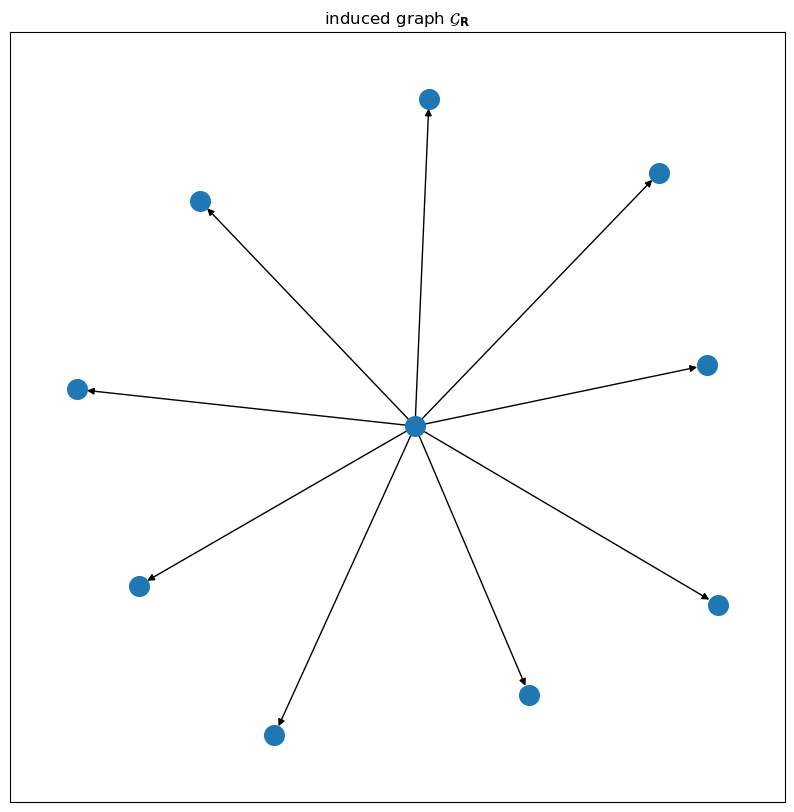

In [14]:
descriptor = "star" if N == 10 else "random"
fig = plt.figure(figsize=(10, 10))

if N == 10:
    nx.draw_networkx(G_R, node_size=200, with_labels=False)
else:
    pos = nx.kamada_kawai_layout(G_R)
    nx.draw_networkx(G_R, node_size=100, with_labels=False, pos=pos)
plt.title(r"induced graph $\mathcal{G}_\mathbf{R}$ ")
plt.show()

if save_plots:
    fig.savefig(f"./{path}/R_{descriptor}_graph_{N}_nodes.pdf", dpi=600, format="pdf")

In [ ]:
fig = plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_C)
if N == 10:
    nx.draw_networkx(G_C, node_size=200, with_labels=False)
else:
    pos = nx.kamada_kawai_layout(G_C)
    nx.draw_networkx(G_C, node_size=100, with_labels=False, pos=pos)
plt.title(r"induced graph $\mathcal{G}_\mathbf{C}$ ")
plt.show()

if save_plots:
    fig.savefig(f"./{path}/C_{descriptor}_graph_{N}_nodes.pdf", dpi=600, format="pdf")